# Chapter 1: Multi-Head Intrusive Regression model
This chapter aims to show how to define a proper loss to modify a classical deterministic regression model to a two-heads intrusive Bayesian approach.

In [1]:
# Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

path_pardir = Path(os.getcwd()).parent
path_data = os.path.join(path_pardir, 'Data')

## S1-1: Introduce MSE loss:
Standard MSE loss is defined as the $\ell_2$ norm between each element of the input (thought as a tensor, is the model prediction $\hat{y} = \mathcal{M}(x)$) and the output (GT: $y$):
$$ \ell (\hat{y}, y) := (\hat{y}-y)^2 $$

In [2]:
# Introduce the MSE loss
loss_MSE = nn.MSELoss()

# Define the ground truth
y_true = torch.tensor([3.0])

# Define a candidate prediction
y_pred = torch.tensor([2.0])
expected_loss = loss_MSE(y_pred,y_true)
print(f"Loss MSE 2 vs 3: {expected_loss}")

# Define THE optimal candidate prediction
y_pred = torch.tensor([3.0])
expected_loss = loss_MSE(y_pred,y_true)
print(f"Loss MSE 3 vs 3: {expected_loss}")

# Define a totally wrong prediction
y_pred = torch.tensor([-17.0])
expected_loss = loss_MSE(y_pred,y_true)
print(f"Loss MSE -17 vs 3: {expected_loss}")

Loss MSE 2 vs 3: 1.0
Loss MSE 3 vs 3: 0.0
Loss MSE -17 vs 3: 400.0


By applying the loss to a batch, the MSE is calculated element by element and averaged or given as a tensor:

In [3]:
# Define the ground truth and prediction as batches
y_true = torch.tensor([3.0, 3.0, 3.0])
y_pred = torch.tensor([2.0, 3.0, -17.0])

# The loss on the batch can be calculated as the average between losses: (1+0+400)/3
loss_MSE = nn.MSELoss() 
loss_MSE = nn.MSELoss(reduction='mean') # Same as default

expected_loss = loss_MSE(y_pred,y_true)
print(f"Loss as average on batch: {expected_loss}")

# Otherwise it can be computed value by value:
loss_MSE = nn.MSELoss(reduction='none')

expected_loss = loss_MSE(y_pred,y_true)
print(f"Loss element wise on batch: {expected_loss}")

Loss as average on batch: 133.6666717529297
Loss element wise on batch: tensor([  1.,   0., 400.])


## S1-2: Introduce NLL (Variance Attenuation) Loss:
We want to define (and understand) how the Variance Attenuation Loss behaves compared to the standard MSE Loss.

The variance attenuation loss is computed as the NLL (Negative Log Likelihood) assuming a Gaussian output of the model:
$$ \text{NLL}(\hat{y},y) := \text{NLL}\left((\mu(x), \sigma(x)),y\right) := \frac{1}{2} \left( \log (\sigma(x)^2)+\frac{(y-\mu(x))^2}{\sigma^2(x)} \right)$$
where it should be noted that the "prediction" of the model is a Gaussian distribution fully characterized by its mean and its std:
$$ \hat{y} = (\mu(x), \sigma(x)) $$
while the GT is a real valued element:
$$ y \in \mathbb{R} $$

To avoid division by zero, the variance is perturbed with a positive term $\varepsilon$:
$$ \sigma^2(x) \rightarrow \sigma^2(x) + \varepsilon $$

To avoid problems with the output of the model (i.e. a negative variance), we can act on the last layer of the ANNs or simply think of the output of the last layer as $(\mu(x), \log(\sigma(x))$ in such a way that negative values are automatically converted to variances by applying an exponential function. To improve readibility, we decided to modify the ANNs such that the secundary output is always positive.


We need to define the loss from scratches, in Pytorch, as follows

In [4]:
# Extend Pytorch Module to define a "Variance Attenuation Loss":
class VarianceAttenuationLoss(nn.Module):
    def __init__(self, epsilon = 1e-6, set_to_zero = False):
        super(VarianceAttenuationLoss, self).__init__()
        
        # To avoid division by 0 add a perturbatuion:
        self.epsilon = epsilon  

        # Boolean switch to decide to translate the NLL:
        self.set_to_zero = set_to_zero
        

    def forward(self, y_pred, y_true):
        # Assuming y_pred has two outputs: mean and std:
        # Mean
        mean = y_pred[:, 0].unsqueeze(1)
        # Std
        variance = y_pred[:, 1].unsqueeze(1)**2 + self.epsilon # Add a perturbation 

        # Negative Log Likelihood
        nll = 0.5 * (torch.log(variance) + ((y_true - mean)**2)/variance)

        # Translate the minumum to zero
        if self.set_to_zero:
            nll = nll - 0.5*torch.log(torch.ones_like(nll)*self.epsilon)

        # Return the mean (on the batch)
        return torch.mean(nll)

Test on some cases how the NLL behaves:

In [9]:
# Initialize the loss:
loss_VA = VarianceAttenuationLoss(set_to_zero = True)

# The ground truth is a VALUE:
y_true = torch.tensor([12.7])

# The best outcome for VarianceAttenuationLoss is the prediction = GT and null std
y_pred = torch.tensor([[12.7, 0]])
expected_loss = loss_VA(y_pred,y_true)
print(f"Correct & reliable prediction: {expected_loss}")

# Making the perfect prediction with high std (unreliable estimate) increases the loss:
y_pred = torch.tensor([[12.7, 5]])
expected_loss = loss_VA(y_pred,y_true)
print(f"Correct & un-reliable prediction: {expected_loss}")

# Bad prediction with low reliability provides low loss:
y_pred = torch.tensor([[16.9, 5]])
expected_loss = loss_VA(y_pred,y_true)
print(f"\nWrong & un-reliable prediction: {expected_loss}")

# Bad (reliable) predictions are highly penalized:
y_pred = torch.tensor([[16.9, 1]])
expected_loss = loss_VA(y_pred,y_true)
print(f"Wrong & reliable prediction: {expected_loss}")

Correct & reliable prediction: 0.0
Correct & un-reliable prediction: 8.517192840576172

Wrong & un-reliable prediction: 8.869993209838867
Wrong & reliable prediction: 15.727745056152344


NLL can also be calculated on batches:

In [11]:
# Model outputs both mean and log_variance
y_pred = torch.tensor([[2.5, 13], [23.9, -4]], requires_grad= True)  # Batch = [[mean_1, std_1],[mean_2, std_2],...]
y_true = torch.tensor([2.4, 17.8])

criterion = VarianceAttenuationLoss()
loss = criterion(y_pred, y_true)
loss.backward()

print("Loss:", loss.item())

Loss: 6.050803184509277


## S1-3: Regression multi-head model
This is an elementary implementation of a multi-head regression model in Pytorch using the Variance Attenuation Loss.

First, we define the device (GPU/CPU) we are working with:

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


The data frame is the linear relationship without noise introduced in step_1, we explicitly split the data frame into training/validation/test set.

In [13]:
chosen_df = "df_nonlinear_heteroscedastic_aleatoric.csv"

full_df = pd.read_csv(os.path.join(path_data, chosen_df))

training_df = full_df[full_df["split_label"]==0]
validation_df = full_df[full_df["split_label"]==1]
test_df = full_df[full_df["split_label"]==2]

full_df.head(8)

,x_range,y_range,split_label
0,-100.00000,-2.301985,0
1,-99.89995,-1.904300,0
2,-99.79990,-1.670993,2
3,-99.69985,-2.122477,2
4,-99.59980,-1.778223,0
5,-99.49975,-2.057319,1
6,-99.39970,-2.118222,0
7,-99.29965,-2.110165,0


We define a CustomDataset from Pytorch Dataset. The dataset has an *init* (initialise the class), a *len* and a *getitem* method.
A Dataset must provide the tools to identify available data and return all the elements needed to train/test/evaluate the model.

Can be skipped if the data is particularly simple.

In [14]:
# Dataset definition:
class CustomDataset(Dataset):
    def __init__(self, annotations_file, path_data, split_label=None):
        if split_label!=None:
            self.df = pd.read_csv(os.path.join(path_data, annotations_file))
            self.df = self.df[self.df['split_label']==split_label]
        else:
            self.df = pd.read_csv(os.path.join(path_data, annotations_file))

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x_range = float(self.df.iloc[idx]['x_range'])
        y_range = float(self.df.iloc[idx]['y_range'])

        features = torch.tensor([x_range], dtype=torch.float32)
        output = torch.tensor([y_range], dtype=torch.float32)
        
        return features, output

# Initialize Training dataset and show outputs and properties:
training_dataset = CustomDataset(annotations_file=chosen_df, path_data=path_data, split_label=0)
print("Length training dataset:", training_dataset.__len__())

index_example = 27
print(f"Output example (x_range,y_range)=({training_dataset.__getitem__(index_example)}) with index {index_example}.")

# Initialize validation and test datasets:
validation_dataset = CustomDataset(annotations_file=chosen_df, path_data=path_data, split_label=1)
test_dataset = CustomDataset(annotations_file=chosen_df, path_data=path_data, split_label=2)

Length training dataset: 1600
Output example (x_range,y_range)=((tensor([-96.3982]), tensor([-1.3383]))) with index 27.


To define a batch we can iterate on the whole dataset or define a *DataLoader* which samples from the introduced DataSet and can be iterated during training. It provides a batch of tensors to apply the computations efficiently at the same time.

In [15]:
# Size of each batch
batch_size = 10 

# Define 3 DataLoaders: Training/Validation/Test 
training_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# An example of iteration on the DataLoader:
x_example, y_example = next(iter(training_dataloader))
print(f"(x_example,y_example)=({x_example},{y_example})")
print(f"Data loaded shape: {x_example.shape}")

(x_example,y_example)=(tensor([[ -5.5528],
        [ 55.4777],
        [-70.6853],
        [-37.2686],
        [ 80.6903],
        [ 42.7714],
        [ 52.8764],
        [-78.8894],
        [ 93.9970],
        [-22.5613]]),tensor([[-0.3427],
        [-1.0643],
        [-0.1042],
        [-1.0179],
        [-2.0970],
        [ 0.0286],
        [-0.5557],
        [-0.2578],
        [-2.4660],
        [-1.0608]]))
Data loaded shape: torch.Size([10, 1])


Introduce a (small) model to approximate the relationship, now we need a model wich provides as output 2 values instead of one (mean and standard deviation)

In [16]:
class TwoHeads(nn.Module):
    def __init__(self):
        super(TwoHeads, self).__init__()
        # Define the layers of the network
        self.hidden = nn.Sequential(
            nn.Linear(1, 8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU()
        )

        # Define the last layer as a mean and standard deviation:
        self.mean = nn.Linear(16, 1)  # Output the mean
        self.std = nn.Linear(16, 1)   # Output the std

        # Constant initialization of std to avoid too high values that stop gradient flow
        nn.init.constant_(self.std.weight, 0.1)
        nn.init.constant_(self.std.bias, 0.5)
        
        
    def forward(self, x):
        # Collect the output of the hidden layers:
        x = self.hidden(x)

        # Compute mean from the hidden layer:
        mean = self.mean(x)

        # Compute std from the hidden layer:
        std = self.std(x)
        std = torch.nn.functional.softplus(std) # Apply a softplus function to 
        std = torch.clamp(std, min=0.01, max=5) # Clamp the 
        
        return torch.cat([mean, std], dim=1)  # Return both mean and std

# Initialize the model:
model = TwoHeads()

# Move the model to device (GPU):
model.to(device)

# Convert weights type to float:
model = model.float()

Introduce the loss and the optimiser. Both can be implemented explicitly. The loss can be any function relating predictions and ground truths.

In [17]:
# Loss function (Variance Attenuation Loss):
loss_fn = VarianceAttenuationLoss(set_to_zero = True)

# Optimizer (Adam): 
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Training cycle: 
- The model is trained for a given number of epochs *n_epochs*
- Each epoch iterates over the entire dataset (*shuffle == True* just randomly shuffles indices) using the dataloader to generate batches.
- For each batch, the gradients are computed on the whole batch to the respect of the loss function and the optimizer it is used to update model trainable parameters


In [19]:
# Number of training epochs:
n_epochs = 50

training_loss_list = []
validation_loss_list = []

# Iterate over the epochs:
for epoch in range(n_epochs):

    # Set the model to Training mode: This interacts with certain kind of network layers (such as Dropout layers)
    model.train()  

    # Temporary variable to store the loss on the whole epoch as a convergence metric
    running_loss = 0.0

    # Iterate on the whole dataset using the dataloader.
    for x_input, y_output in training_dataloader:
        # Load inputs ad move to device (GPU)
        x_input, y_output = x_input.to(device), y_output.to(device)

        # Clear previous gradients
        optimizer.zero_grad()  
        
        # Forward pass (model calls)
        y_model = model(x_input)  

        # Compute loss (supervised case)
        loss = loss_fn(y_model, y_output)  

       # print(loss)
        # Backpropagation 
        loss.backward()  

        # Update parameters (optimization step)
        optimizer.step()  

        # Update running loss as convergence metric
        running_loss += loss.item()
        

    
    ## Calculate loss on validation as an additional metric to evaluate overfitting
    # Set the model to Evaluation mode:
    model.eval()

    # Temporary variable to store the validation loss:
    running_val_loss = 0.0
    
    # Deactivate gradient computation
    with torch.no_grad():
        for x_input, y_output in validation_dataloader:
            # Load inputs ad move to device (GPU)
            x_input, y_output = x_input.to(device), y_output.to(device)

            # Forward pass (model calls)
            y_model = model(x_input)

            # Compute loss (supervised case)
            loss = loss_fn(y_model, y_output)

            # Update validation running loss as convergence metric
            running_val_loss += loss.item()
            
    # Average epoch loss
    epoch_training_loss = running_loss / len(training_dataloader)
    epoch_validation_loss = running_val_loss / len(validation_dataloader)

    # Append the losses to the list:
    training_loss_list.append(epoch_training_loss)
    validation_loss_list.append(epoch_validation_loss)
            
    # Convergence metric
    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {epoch_training_loss:.4f}, Val. Loss: {epoch_validation_loss:.4f}")

Epoch [1/50], Loss: 7.1505, Val. Loss: 6.8982
Epoch [2/50], Loss: 6.8337, Val. Loss: 6.7436
Epoch [3/50], Loss: 6.6682, Val. Loss: 6.4747
Epoch [4/50], Loss: 6.1912, Val. Loss: 6.1111
Epoch [5/50], Loss: 5.9474, Val. Loss: 6.3069
Epoch [6/50], Loss: 5.8826, Val. Loss: 5.7783
Epoch [7/50], Loss: 5.7854, Val. Loss: 5.6092
Epoch [8/50], Loss: 5.6785, Val. Loss: 5.6381
Epoch [9/50], Loss: 5.6817, Val. Loss: 5.6690
Epoch [10/50], Loss: 5.6045, Val. Loss: 5.5481
Epoch [11/50], Loss: 5.5467, Val. Loss: 5.5024
Epoch [12/50], Loss: 5.5421, Val. Loss: 5.6278
Epoch [13/50], Loss: 5.5625, Val. Loss: 5.4728
Epoch [14/50], Loss: 5.4619, Val. Loss: 5.4123
Epoch [15/50], Loss: 5.4504, Val. Loss: 5.3885
Epoch [16/50], Loss: 5.5214, Val. Loss: 5.3867
Epoch [17/50], Loss: 5.4136, Val. Loss: 5.5668
Epoch [18/50], Loss: 5.3654, Val. Loss: 5.3885
Epoch [19/50], Loss: 5.3885, Val. Loss: 5.2820
Epoch [20/50], Loss: 5.3929, Val. Loss: 5.4332
Epoch [21/50], Loss: 5.3763, Val. Loss: 5.6243
Epoch [22/50], Loss: 5

Plot the convergence graphs on training and validation sets:

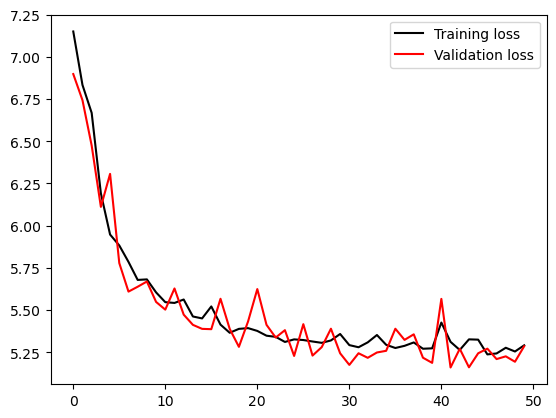

In [20]:
fig, ax = plt.subplots()

ax.plot(list(range(len(training_loss_list))), training_loss_list, color = 'black', label='Training loss')
ax.plot(list(range(len(validation_loss_list))), validation_loss_list,  color = 'red', label='Validation loss')
ax.legend()

Plot the training dataset against the predictions:

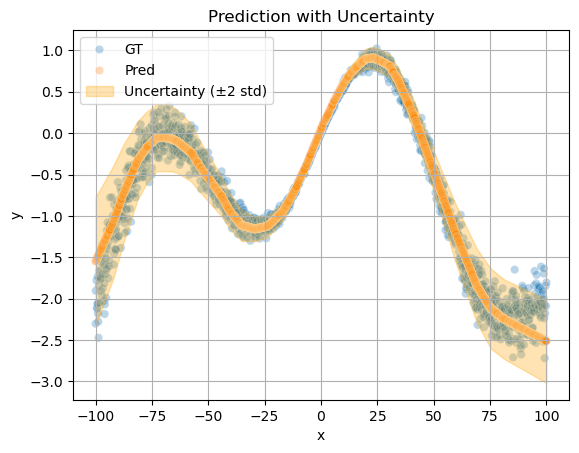

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the dataframe 
x_plot = np.array(training_df["x_range"])  # Input
y_plot = np.array(training_df["y_range"])  # GT
prediction_plot = [float(model(torch.tensor(i).view(1).to(device).float().unsqueeze(1))[0][0].to('cpu')) for i in x_plot]  # Predictions
std_plot = [float(model(torch.tensor(i).view(1).to(device).float().unsqueeze(1))[0][1].to('cpu')) for i in x_plot]         # Std

df_plot_train = pd.DataFrame({
    "x": np.append(x_plot, x_plot),
    "y": np.append(y_plot, prediction_plot),
    "GT/Pred": np.append(["GT"]*len(y_plot), ["Pred"]*len(prediction_plot))
})

# Scatter plot
sns.scatterplot(data=df_plot_train, x="x", y="y", hue="GT/Pred", alpha=0.3)

# Create the prediction bounds for the color zone (±2 std)
lower_bound = np.array(prediction_plot) - 2 * np.array(std_plot)
upper_bound = np.array(prediction_plot) + 2 * np.array(std_plot)

# Add the shaded region between lower_bound and upper_bound
plt.fill_between(x_plot, lower_bound, upper_bound, color='orange', alpha=0.3, label="Uncertainty (±2 std)")

# Adding labels and title
plt.xlabel('x')
plt.ylabel('y')
plt.title('Prediction with Uncertainty')

# Show legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()